In [3]:
import os, sys
import numpy as np
from astropy import units
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from astropy.table import Table, Column
from scipy.optimize import minimize
from lightkurve.lightcurve import LightCurve
from scipy.signal import find_peaks
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d

COLOR = 'k'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 10 #12
plt.rcParams['ytick.major.size']  = 10 #12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 6
plt.rcParams['ytick.minor.size']  = 6

plt.rcParams['axes.linewidth'] = 3

plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'

%load_ext autoreload
%autoreload 2
sys.path.append('/Users/arcticfox/Documents/GitHub/cos_flares/src/')
from utils import *
from cos_flares import FlaresWithCOS

plt.rcParams['font.size'] = 18

def load_data(path, fname='interp_between_1.npy'):
    wavelength, flux, err = load_binned_data(os.path.join(path,fname))

    times = np.load(os.path.join(path,'times.npy'))
    orbits = np.load(os.path.join(path,'orbits.npy'))

    wavelength = np.full(flux.shape, wavelength)
    return wavelength, flux, err, times, orbits

w20, f20, e20, t20, o20 = load_data(path='/Users/arcticfox/Documents/AUMic/30s/reduced')
w30, f30, e30, t30, o30 = load_data(path='/Users/arcticfox/Documents/AUMic/30s/reduced2')

flare_mask = np.load('/Users/arcticfox/Documents/AUMic/flare_mask.npy',
                     allow_pickle=True)

parula = np.load('/Users/arcticfox/parula_colors.npy')
distance = (9.72*units.pc).to(units.cm)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Flares in the 30s data

In [2]:
w30, f30, e30, t30, o30 = load_data(path='/Users/arcticfox/Documents/AUMic/30s/reduced')
w20, f20, e20, t20, o20 = load_data(path='/Users/arcticfox/Documents/AUMic/30s/reduced2')

fwc = FlaresWithCOS(wavelength=np.append(w30, w20, axis=0), 
                    flux=np.append(f30, f20, axis=0),
                    flux_err=np.append(e30, e20, axis=0), 
                    time=np.append(t30, t20)-t30[0], 
                    orbit=np.append(o30, o20+5))

fwc.load_line_table(path='/Users/arcticfox/Documents/GitHub/cos_flares/')
fwc.load_lsf_model(fname='/Users/arcticfox/Documents/AUMic/aa_LSFTable_G130M_1222_LP4_cn.dat')

for ion in fwc.line_table['ion']:
    fwc.measure_ew(ion)

In [4]:
%load_ext autoreload
%autoreload 2
from plot_utils import make_tworow

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
visit2_time = np.append(t30,t20)-t20[0]

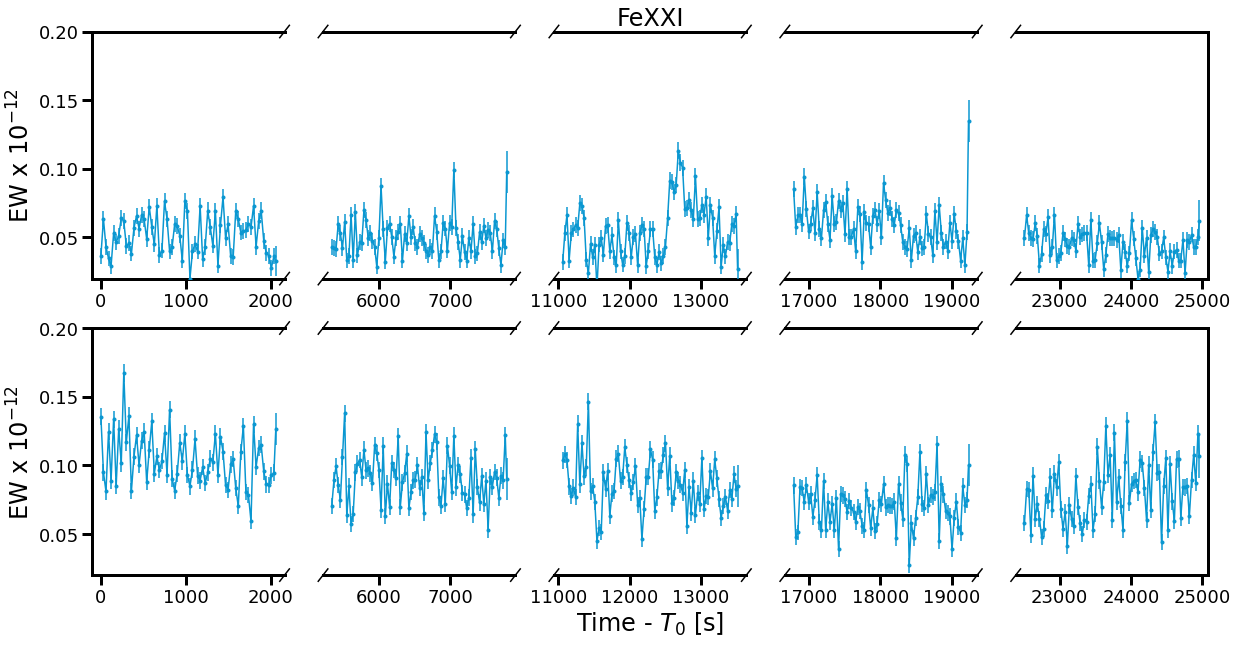

In [6]:
iron = [i for i in fwc.width_table.colnames if 'Fe' in i]

fig, axes = make_tworow()


for i in range(len(axes)):
    q = fwc.orbit == i
    
    if i < 5:
        t = fwc.time.value + 0.0
    else:
        t = visit2_time + 0.0
        
    
    axes[i].errorbar(t[q],
                     fwc.width_table[iron[1]].data[q]/10e-12, 
                     yerr=fwc.error_table[iron[1]].data[q]/10/10e-12,
                     marker='.',  color=parula[80], zorder=3)
    
    inds = np.where(np.array(flare_mask[1])==i)[0]
    
    if i == 2:
        axes[i].set_title(iron[1], fontsize=24)
        
    axes[i].set_ylim(0.02,0.2)
    #axes[i].set_ylim(1e-14,1e-12)
        
    if i == 0 or i == 5:
        axes[i].set_ylabel('EW x 10$^{-12}$', fontsize=24)
        #axes[i].set_yticks(np.arange(1e-14,1e-12, 3e-13))
        #axes[i].set_yticklabels(np.arange(1e-14,1e-12, 3e-13)/1e-12)
    if i == 7:
        axes[i].set_xlabel('Time - $T_0$ [s]', fontsize=24)
#plt.savefig('/Users/arcticfox/Documents/AUMic/figures/FeXXI.png', dpi=250,
#            rasterize=True, bbox_inches='tight')

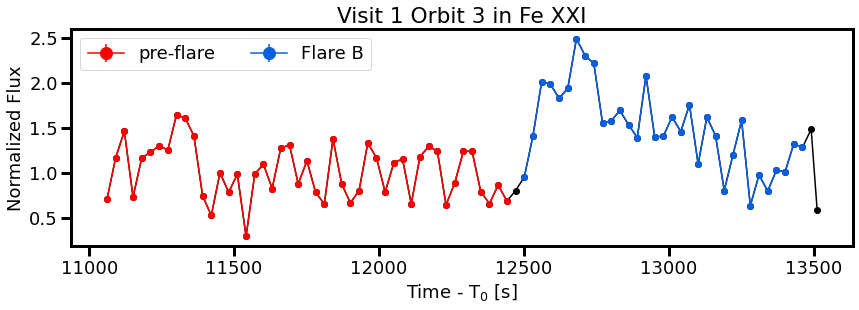

In [6]:
fig = plt.figure(figsize=(14,4))
fig.set_facecolor('w')
t = fwc.time.value
q = (t < 1e6) & (fwc.orbit==2)
oof = (t < 1e6) & (fwc.orbit==2) & (t<12450)

plt.errorbar(t[q],
             fwc.width_table['FeXXI'].data[q]/np.nanmedian(fwc.width_table['FeXXI'].data[oof]),
             yerr=fwc.error_table['FeXXI'].data[q],
             marker='o', color='k', zorder=3)

plt.errorbar(t[oof],
             fwc.width_table['FeXXI'].data[oof]/np.nanmedian(fwc.width_table['FeXXI'].data[oof]),
             yerr=fwc.error_table['FeXXI'].data[oof],
             marker='o', color='red', zorder=3, label='pre-flare')

fb = (t < 1e6) & (flare_mask[2][2]>0) & (t>12500)

plt.errorbar(t[fb][:-1],
             fwc.width_table['FeXXI'].data[fb][:-1]/np.nanmedian(fwc.width_table['FeXXI'].data[oof]),
             yerr=fwc.error_table['FeXXI'].data[fb][:-1],
             marker='o',  color=parula[30], zorder=3, label='Flare B')
plt.title('Visit 1 Orbit 3 in Fe XXI')
plt.xlabel('Time - T$_0$ [s]')
plt.ylabel('Normalized Flux')
plt.legend(ncol=2)
#plt.savefig('/Users/arcticfox/Desktop/visit1orbit3iron.png', dpi=250, rasterize=True,
#            bbox_inches='tight')

[17114.99193573 17144.99193573 17174.99193573 17204.99193573
 17234.99193573 17264.99193573 17294.99193573 17324.99193573
 17354.99193573 17384.99193573 17414.99193573 17444.99193573
 17474.99193573 17504.99193573 17534.99193573 17564.99193573
 17594.99193573]
6.090862130033396e-13 1.2453384484763787e-13


/var/folders/gz/h7_ym7m52dlgq4xpllc1x3m40000gn/T/ipykernel_26417/3496439438.py:39: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('/Users/arcticfox/Desktop/visit1orbit4iron.png', dpi=250, rasterize=True,


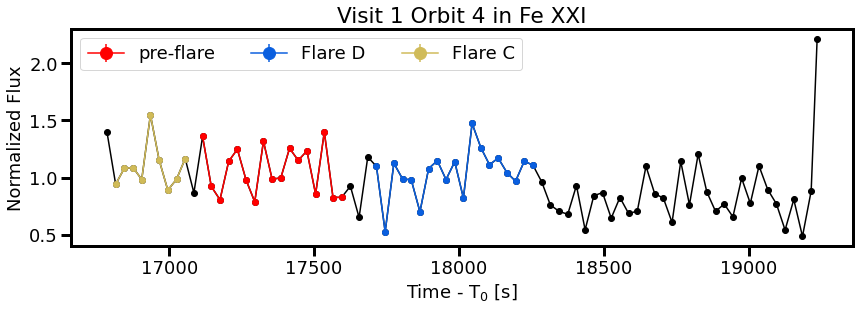

In [12]:
fig = plt.figure(figsize=(14,4))
fig.set_facecolor('w')
t = fwc.time.value
q = (t < 1e6) & (fwc.orbit==3)
oof = (t < 1e6) & (fwc.orbit==3) & (t>17090) & (t<17600)

plt.errorbar(t[q],
             fwc.width_table['FeXXI'].data[q]/np.nanmedian(fwc.width_table['FeXXI'].data[oof]),
             yerr=fwc.error_table['FeXXI'].data[q],
             marker='o', color='k', zorder=3)

plt.errorbar(t[oof],
             fwc.width_table['FeXXI'].data[oof]/np.nanmedian(fwc.width_table['FeXXI'].data[oof]),
             yerr=fwc.error_table['FeXXI'].data[oof],
             marker='o', zorder=3, color='red', label='pre-flare')
print(t[oof])
print(np.nanmedian(fwc.width_table['FeXXI'].data[oof]),
      np.nanstd(fwc.width_table['FeXXI'].data[oof]))

fb = (t < 1e6) & (flare_mask[2][4]>0) & (t>12500)

plt.errorbar(t[fb][:-1],
             fwc.width_table['FeXXI'].data[fb][:-1]/np.nanmedian(fwc.width_table['FeXXI'].data[oof]),
             yerr=fwc.error_table['FeXXI'].data[fb][:-1],
             marker='o',  color=parula[30], zorder=3, label='Flare D')

fb = (t < 1e6) & (flare_mask[2][3]>0) & (t>12500)

plt.errorbar(t[fb][:-1],
             fwc.width_table['FeXXI'].data[fb][:-1]/np.nanmedian(fwc.width_table['FeXXI'].data[oof]),
             yerr=fwc.error_table['FeXXI'].data[fb][:-1],
             marker='o',  color=parula[190], zorder=3, label='Flare C')

plt.legend(ncol=3)
plt.title('Visit 1 Orbit 4 in Fe XXI')
plt.xlabel('Time - T$_0$ [s]')
plt.ylabel('Normalized Flux')

plt.savefig('/Users/arcticfox/Desktop/visit1orbit4iron.png', dpi=250, rasterize=True,
            bbox_inches='tight')

[18404.99193573 18434.99193573 18464.99193573 18494.99193573
 18524.99193573 18554.99193573 18584.99193573 18614.99193573
 18644.99193573 18674.99193573 18704.99193573 18734.99193573
 18764.99193573 18794.99193573 18824.99193573 18854.99193573
 18884.99193573 18914.99193573 18944.99193573 18974.99193573
 19004.99193573 19034.99193573 19064.99193573 19094.99193573
 19124.99193573 19154.99193573 19184.99193573 19214.99193573]
4.973347990738528e-13 1.0831872059964484e-13


/var/folders/gz/h7_ym7m52dlgq4xpllc1x3m40000gn/T/ipykernel_26417/2408194330.py:39: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('/Users/arcticfox/Desktop/visit1orbit4iron_take2.png', dpi=250, rasterize=True,


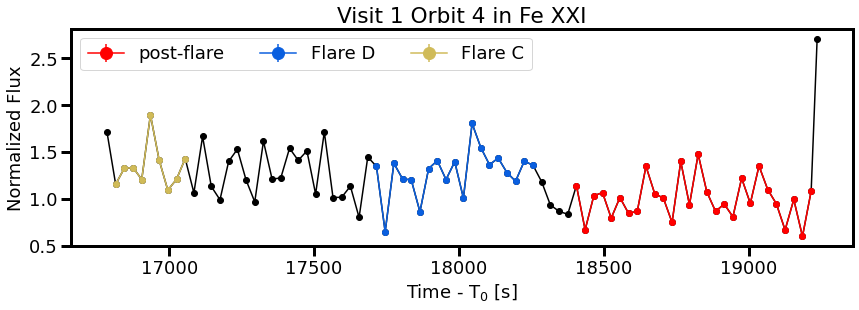

In [10]:
fig = plt.figure(figsize=(14,4))
fig.set_facecolor('w')
t = fwc.time.value
q = (t < 1e6) & (fwc.orbit==3)
oof = (t < 19230) & (fwc.orbit==3) & (t>=18400)

plt.errorbar(t[q],
             fwc.width_table['FeXXI'].data[q]/np.nanmedian(fwc.width_table['FeXXI'].data[oof]),
             yerr=fwc.error_table['FeXXI'].data[q],
             marker='o', color='k', zorder=3)

plt.errorbar(t[oof],
             fwc.width_table['FeXXI'].data[oof]/np.nanmedian(fwc.width_table['FeXXI'].data[oof]),
             yerr=fwc.error_table['FeXXI'].data[oof],
             marker='o', zorder=3, color='red', label='post-flare')
print(t[oof])
print(np.nanmedian(fwc.width_table['FeXXI'].data[oof]),
      np.nanstd(fwc.width_table['FeXXI'].data[oof]))

fb = (t < 1e6) & (flare_mask[2][4]>0) & (t>12500)

plt.errorbar(t[fb][:-1],
             fwc.width_table['FeXXI'].data[fb][:-1]/np.nanmedian(fwc.width_table['FeXXI'].data[oof]),
             yerr=fwc.error_table['FeXXI'].data[fb][:-1],
             marker='o',  color=parula[30], zorder=3, label='Flare D')

fb = (t < 1e6) & (flare_mask[2][3]>0) & (t>12500)

plt.errorbar(t[fb][:-1],
             fwc.width_table['FeXXI'].data[fb][:-1]/np.nanmedian(fwc.width_table['FeXXI'].data[oof]),
             yerr=fwc.error_table['FeXXI'].data[fb][:-1],
             marker='o',  color=parula[190], zorder=3, label='Flare C')

plt.legend(ncol=3)
plt.title('Visit 1 Orbit 4 in Fe XXI')
plt.xlabel('Time - T$_0$ [s]')
plt.ylabel('Normalized Flux')

plt.savefig('/Users/arcticfox/Desktop/visit1orbit4iron_take2.png', dpi=250, rasterize=True,
            bbox_inches='tight')

/var/folders/gz/h7_ym7m52dlgq4xpllc1x3m40000gn/T/ipykernel_26417/3435981457.py:32: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('/Users/arcticfox/Desktop/visit2orbit5iron.png', dpi=250, rasterize=True,


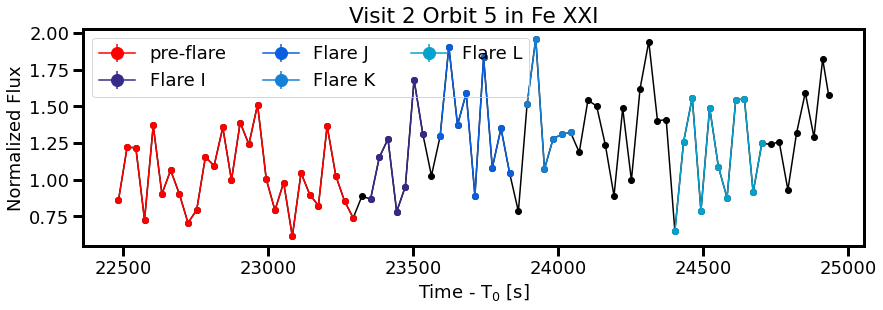

In [9]:
fig = plt.figure(figsize=(14,4))
fig.set_facecolor('w')
t = visit2_time + 0.0
q = (t < 1e6) & (fwc.orbit==9)
oof = (t < 1e6) & (fwc.orbit==9) & (t<23300) 

plt.errorbar(t[q],
             fwc.width_table['FeXXI'].data[q]/np.nanmedian(fwc.width_table['FeXXI'].data[oof]),
             yerr=fwc.error_table['FeXXI'].data[q],
             marker='o', color='k', zorder=3)

plt.errorbar(t[oof],
             fwc.width_table['FeXXI'].data[oof]/np.nanmedian(fwc.width_table['FeXXI'].data[oof]),
             yerr=fwc.error_table['FeXXI'].data[oof],
             marker='o', zorder=3, color='red', label='pre-flare')

letters =['I', 'J','K','L']
for i, ind in enumerate([-4,-3,-2,-1]):
    fb = (t < 1e6) & (flare_mask[2][ind]>0)

    plt.errorbar(t[fb][:-1],
                 fwc.width_table['FeXXI'].data[fb][:-1]/np.nanmedian(fwc.width_table['FeXXI'].data[oof]),
                 yerr=fwc.error_table['FeXXI'].data[fb][:-1],
                 marker='o',  color=parula[i*30], zorder=3, 
                 label='Flare {}'.format(letters[i]))


plt.legend(ncol=3)
plt.title('Visit 2 Orbit 5 in Fe XXI')
plt.xlabel('Time - T$_0$ [s]')
plt.ylabel('Normalized Flux')
plt.savefig('/Users/arcticfox/Desktop/visit2orbit5iron.png', dpi=250, rasterize=True,
            bbox_inches='tight')

In [ ]:
iron = [i for i in fwc.width_table.colnames if 'Fe' in i]

fig, axes = make_tworow()


for i in range(len(axes)):
    q = fwc.orbit == i
    
    if i < 5:
        t = fwc.time.value + 0.0
    else:
        t = visit2_time + 0.0
    
    axes[i].errorbar(t[q],
                     fwc.width_table[iron[0]].data[q], 
                     yerr=fwc.error_table[iron[0]].data[q]/10,
                     marker='.',  color=parula[3], zorder=3)
    
    inds = np.where(np.array(flare_mask[1])==i)[0]
    if len(inds)>0:
        for n in inds:
            argmax = np.argmax(fwc.width_table['SiIII'][flare_mask[2][n]>0])
            axes[i].vlines(t[flare_mask[2][n]>0][argmax],
                           0, 1, color=parula[215], lw=3, zorder=1)#, linestyle='--')
    
    if i == 2:
        axes[i].set_title(iron[0], fontsize=24)
        
    #axes[i].set_ylim(0.9e-12,1e-14)
    axes[i].set_ylim(1e-14,1e-12)
        
    if i == 0 or i == 5:
        axes[i].set_ylabel('EW x 10$^{-12}$', fontsize=24)
        axes[i].set_yticks(np.arange(1e-14,1e-12, 3e-13))
        axes[i].set_yticklabels(np.arange(1e-14,1e-12, 3e-13)/1e-12)
    if i == 7:
        axes[i].set_xlabel('Time - $T_0$ [s]', fontsize=24)
#plt.savefig('/Users/arcticfox/Documents/AUMic/figures/FeXIX.png', dpi=250,
#            rasterize=True, bbox_inches='tight')

# Creates the flare masks

In [ ]:
diff = np.where(np.diff(fwc.time.value)>100000)[0]
diff = [0, diff[0], len(fwc.time)-1]

fig, axes = plt.subplots(figsize=(25,8), nrows=2, ncols=5)
fig.set_facecolor('w')
axes = axes.reshape(-1)

f_tot = np.full((20,len(fwc.time.value)), False)
x = 0
a = 0
which_o = []
for i in range(len(diff)-1):
    if i == 0:
        jr = [0,5]
        axes[a].set_ylim(1e-13,4e-11)
    else:
        jr = [5,10]
        
        
    for j in range(jr[0], jr[1]):
        mask = np.where((fwc.time.value>=fwc.time.value[diff[i]]) &
                        (fwc.time.value<=fwc.time.value[diff[i+1]]) &
                        (fwc.orbit==j))
        axes[a].errorbar(fwc.time.value[mask], 
                     fwc.width_table['CIII'][mask], 
                     yerr=fwc.error_table['CIII'][mask]/3, 
                     marker='.', color='k',
                     linestyle='')
        axes[a].plot(fwc.time.value[mask], 
                     fwc.width_table['CIII'][mask], 'k')

        
        if j == 1:
            f = ((fwc.time.value>=6300) & (fwc.time.value<=6600))
            f = f.reshape((1,len(f)))
            which_o.append(j)
        elif j == 2:
            f1 = ((fwc.time.value>=11900) & (fwc.time.value<=12100))
            f2 = ((fwc.time.value>=12300) & (fwc.time.value<=13500)) 
            f = np.array([f1, f2])
            which_o.append(j)
            which_o.append(j)
        elif j == 3:
            f1 = ((fwc.time.value>=16800) & (fwc.time.value<=17100) )
            f2 = ((fwc.time.value>=17700) & (fwc.time.value<=18300) ) 
            f = np.array([f1, f2])
            which_o.append(j)
            which_o.append(j)
        elif j == 4:
            f1 = ((fwc.time.value>=22970) & (fwc.time.value<=23150) )
            f = np.array([f1])
            which_o.append(j)
        elif j == 5:
            f = ((fwc.time.value>=10238383) & (fwc.time.value<=10238593))
            f = f.reshape((1,len(f)))
            which_o.append(j)
        elif j == 8:
            f = ((fwc.time.value>=10254152) & (fwc.time.value<=10254452))
            f = f.reshape((1,len(f)))
            which_o.append(j)
        elif j == 9:
            f0 = ((fwc.time.value>=10259581) & (fwc.time.value<=10259781))
            f1 = ((fwc.time.value>=10260101) & (fwc.time.value<=10260351))
            f2 = ((fwc.time.value>10260351) & (fwc.time.value<=10260651))
            f3 = ((fwc.time.value>10260651) & (fwc.time.value<=10260851))
            f4 = ((fwc.time.value>10261151) & (fwc.time.value<=10261501))
            f = np.array([f0, f1, f2, f3, f4])
            which_o.append(j)
            which_o.append(j)
            which_o.append(j)
            which_o.append(j)
            which_o.append(j)
        else:
            f = None
            
            
        if f is not None:
            for k in range(len(f)):
                f_tot[x] = f[k] 
                m1 = f[k] == True
                #axes[a].errorbar(fwc.time.value[m1], 
                #             fwc.width_table['CIII'][m1], 
                #             yerr=fwc.error_table['CIII'][m1]/3, 
                #             marker='.', color=parula[(k*40)+30],
                #             linestyle='')
                axes[a].axvspan(fwc.time.value[m1][0], fwc.time.value[m1][-1],
                                color=parula[(k*40)+30], alpha=0.4)
                x += 1
            
        if j < 5:
            axes[a].set_ylim(1e-13,5e-11)
        else:
            axes[a].set_ylim(1e-12,4e-11)
            if j == 5:
                axes[a].set_ylabel('EW x $ 10^{-11}$', y=1.1, fontsize=26)
            if j == 7:
                axes[a].set_xlabel('Time [s]', fontsize=26)
                
        axes[a].set_yticklabels([1,2,3,4,5,6])
        if j < 5:
            axes[a].set_title('Visit 1; Orbit {}'.format(j+1))
        else:
            axes[a].set_title('Visit 2; Orbit {}'.format(j-4))
        axes[a].set_xlim(fwc.time.value[mask][0], fwc.time.value[mask][-1])
        a += 1
plt.subplots_adjust(hspace=0.4)
#plt.savefig('/Users/arcticfox/Documents/AUMic/figures/allflares.png', dpi=250, rasterize=True,
#            bbox_inches='tight')

In [ ]:
f_tot = np.delete(f_tot, np.arange(x,len(f_tot),1,dtype=int),axis=0)

In [ ]:
f_int = np.zeros(f_tot.shape, dtype=int)
for i in range(len(f_tot)):
    f_int[i] = (f_tot[i]+0.0)*2**(i+1)

In [ ]:
#np.save('/Users/arcticfox/Documents/AUMic/flare_mask.npy', [fwc.time, which_o, f_int])

# If flare mask created, start below

In [7]:
_, which_o, f_int = np.load('/Users/arcticfox/Documents/AUMic/flare_mask.npy',
                            allow_pickle=True)

In [8]:
def multi_peaks(ttest, test):
    """
    test = time
    ttest = flux
    """

    #plt.plot(ttest, test-test.min(),'k')
    #plt.plot(ttest, test-test.min(), '.')

    p1 = np.argmax(test)
    #plt.plot(ttest[p1], test[p1], 'ro')
    
    try:
        arg = np.where((ttest.value>ttest[p1].value+100))[0]
        p2 = np.argmax(test[arg])
        #plt.plot(ttest[arg][p2], test[arg][p2], 'bo')
    except:
        arg=np.arange(0,len(ttest),1,dtype=int)
        p2=0
        
    try:
        arg3 = np.where((ttest.value>ttest[arg][p2].value+100))[0]
        p3 = np.argmax(test[arg3])
        #plt.plot(ttest[arg3][p3], test[arg3][p3], 'ko')

    except:
        arg3=np.arange(0,len(ttest),1,dtype=int)
        p3=0
        
    t0 = np.array([ttest[p1].value, ttest[arg][p2].value, ttest[arg3][p3].value])
    amp = np.array([test[p1], test[arg][p2], test[arg3][p3]])#/1e-13

    return t0, amp

In [9]:
%load_ext autoreload
%autoreload 2
sys.path.append('/Users/arcticfox/Documents/GitHub/cos_flares/src/')
from utils import *
from cos_flares import FlaresWithCOS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Broad band flares

In [10]:
ions = ['SiII', 'SiIII', 'CIII','NV_1','FeXXI']

In [11]:
f = np.zeros(len(fwc.time))
e = np.zeros(len(fwc.time))
for i in range(len(fwc.time)):
    f[i] = np.trapz(fwc.flux[i]*fwc.flux_units, x=fwc.wavelength[i]*units.AA).value
    e[i] = np.trapz(fwc.flux_err[i]**2*fwc.flux_units,x=fwc.wavelength[i]*units.AA).value
    e[i] = np.sqrt(e[i]/len(fwc.flux_err[i]))

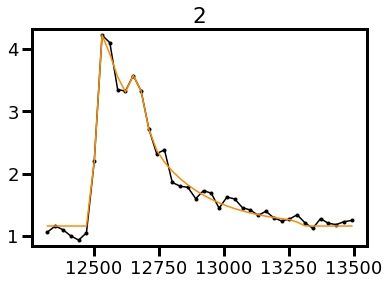

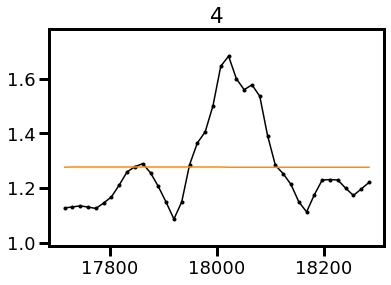

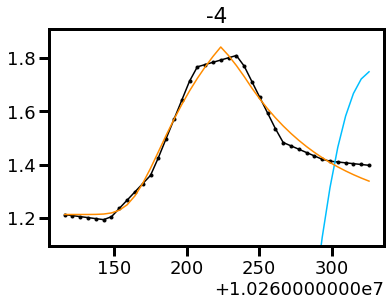

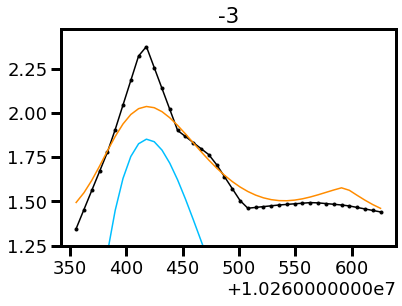

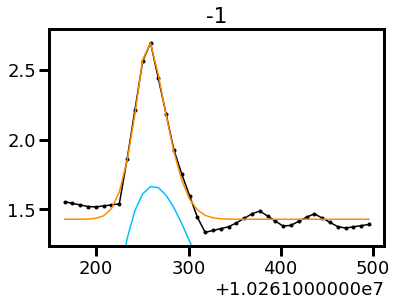

In [12]:
fmodels_all = []

for j in [2,4,-4,-3,-1]:
    
    mask = f_int[j] > 0
    
    upsample = np.linspace(fwc.time[mask].min(), fwc.time[mask].max(), 40)
    
    if ion !='CIII':
        finterp = interp1d(fwc.time[mask], f[mask]/1e-12)
        einterp = interp1d(fwc.time[mask], e[mask]/1e-12)
    else:
        finterp = interp1d(fwc.time[mask], f[mask]/1e-11)
        einterp = interp1d(fwc.time[mask], e[mask]/1e-11)
    
    plt.plot(upsample, 
             finterp(upsample),
             marker='.', color='k')
    
    t0, amp = multi_peaks(fwc.time[mask], f[mask])
    rise, decay = [10,10,10],[50,50,50] 
    
    
    if j==2:
        out = fwc.fit_flare(ion=ion, mask=mask, model='convolved',
                            eta=t0-20, omega=np.full(3,50), 
                            alpha=np.full(3,50),offset=np.ones(3)+1,
                            amp=amp/1e-12*10, t0=t0, rise=rise, decay=decay,
                            x=upsample.value, y=finterp(upsample),
                            yerr=einterp(upsample))
    elif j == -3:
        out = fwc.fit_flare(ion=ion, mask=mask, model='convolved',
                            eta=t0[:2]-20, omega=np.full(2,50), 
                            alpha=np.full(2,150),offset=np.ones(2)+1,
                            amp=amp[:2]/1e-12*10, t0=t0[:2]+50, 
                            rise=rise[:2], decay=decay[:2],
                            x=upsample.value, y=finterp(upsample),
                            yerr=einterp(upsample))
    elif j == -4 or j == -1:
        out = fwc.fit_flare(ion=ion, mask=mask, model='convolved',
                            eta=t0[:1]-20, omega=[50], alpha=[150],offset=[1],
                            amp=amp[:1]/1e-12*10,t0=t0[:1]+50, rise=rise[:1], decay=decay[:1],
                            x=upsample.value, y=finterp(upsample))
    else:
        out = fwc.fit_flare(ion=ion, mask=mask, model='convolved',
                            eta=t0[:1]-120, omega=[50], 
                            alpha=[350],offset=[1],
                            amp=amp[:1]/1e-12*10,t0=t0[:1]-80, rise=rise[:1], decay=[1],
                            x=upsample.value, y=finterp(upsample))
        
    plt.plot(upsample, out[-2], color='deepskyblue')
    plt.plot(upsample, out[-1].best_fit, color='darkorange')
    plt.ylim(np.nanmin(finterp(upsample))-0.1, np.nanmax(finterp(upsample))+0.1)
    fmodels_all.append(out)
    plt.title(j)
    plt.show()

## Visit 1 Orbit 2 flares

In [13]:
ions = ['SiII', 'SiIII', 'CIII','NV_1','FeXXI']

SiII


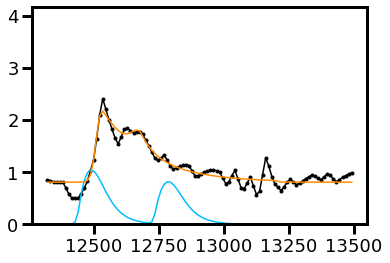

SiIII


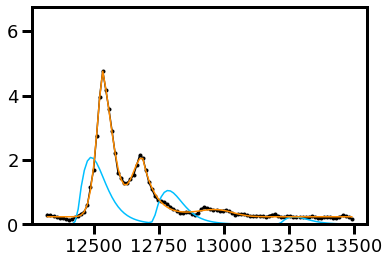

CIII


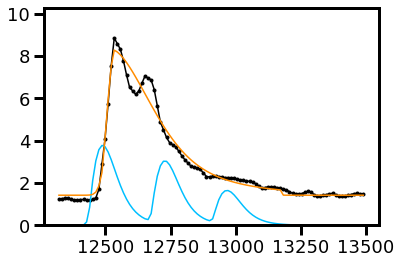

NV_1


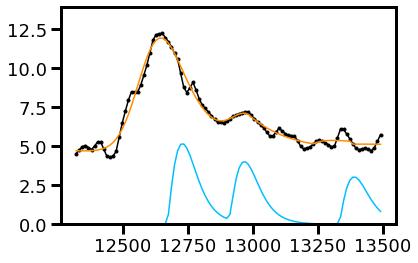

FeXXI


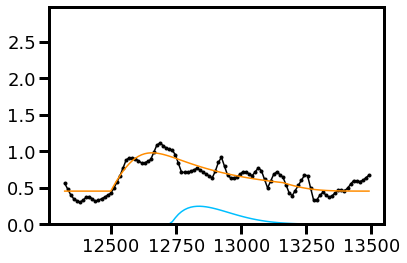

In [14]:
fmodels = []

mask = f_int[2] > 0
tmp1 = []

for ion in ions:
    print(ion)
    
    upsample = np.linspace(fwc.time[mask].min(), fwc.time[mask].max(), 100)
    
    if ion !='CIII':
        finterp = interp1d(fwc.time[mask], fwc.width_table[ion][mask]/1e-12)
        einterp = interp1d(fwc.time[mask], fwc.error_table[ion][mask]/1e-12)
        scaling=1e-12
    else:
        finterp = interp1d(fwc.time[mask], fwc.width_table[ion][mask]/1e-11)
        einterp = interp1d(fwc.time[mask], fwc.error_table[ion][mask]/1e-11)
        scaling=1e-11
    
    plt.plot(upsample, 
             finterp(upsample),
             marker='.', color='k')
    
    t0, amp = multi_peaks(fwc.time[mask], fwc.width_table[ion][mask])
    rise, decay = [10,10,10],[50,50,50] 
    
    
    if ion == 'SiIII' or ion == 'CIII' or ion=='NV_1':
        out = fwc.fit_flare(ion=ion, mask=mask, model='convolved',
                            eta=t0-20, omega=np.full(3,50), 
                            alpha=np.full(3,50),
                            amp=amp/scaling*10, t0=t0+300, rise=rise, decay=decay,
                            x=upsample.value, y=finterp(upsample),
                            yerr=einterp(upsample))
    elif ion == 'SiII':
        out = fwc.fit_flare(ion=ion, mask=mask, model='convolved',
                            eta=t0[:2]-20, omega=np.full(2,50), 
                            alpha=np.full(2,50),
                            amp=amp[:2]/scaling*10, t0=t0[:2]+300, 
                            rise=rise[:2], decay=decay[:2],
                            x=upsample.value, y=finterp(upsample),
                            yerr=einterp(upsample))
    else:
        out = fwc.fit_flare(ion=ion, mask=mask, model='convolved',
                            eta=t0[:1]-20, omega=[150], alpha=[50],
                            amp=amp[:1]/1e-12*10,t0=t0[:1]+300, rise=rise[:1], decay=decay[:1],
                            x=upsample.value, y=finterp(upsample))#,
                            #yerr=einterp(upsample))
    plt.plot(upsample, out[-2], color='deepskyblue')
    plt.plot(upsample, out[-1].best_fit, color='darkorange')
    plt.ylim(0, np.nanmax(out[-1].best_fit)+2)
    tmp1.append(out)
    plt.show()

fmodels.append(tmp1)

## Visit 2 Orbit 5 flares

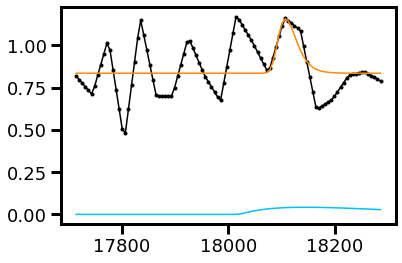

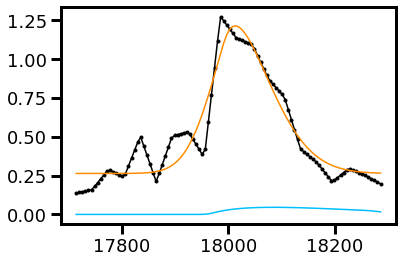

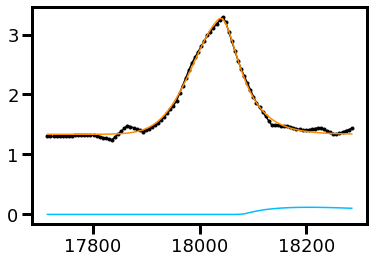

[17954.99193573]


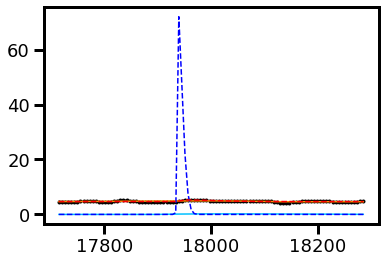

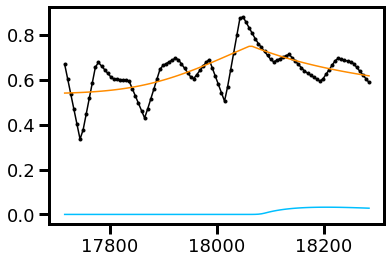

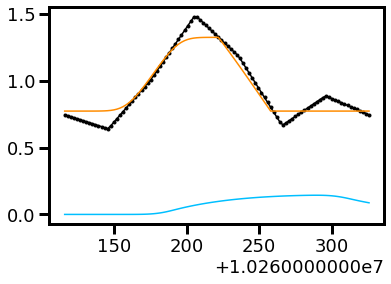

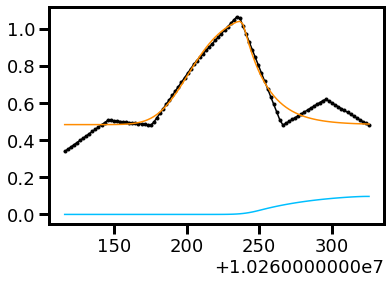

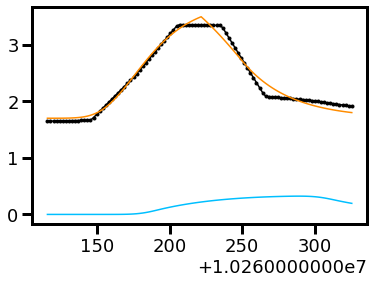

[10260205.66579151]


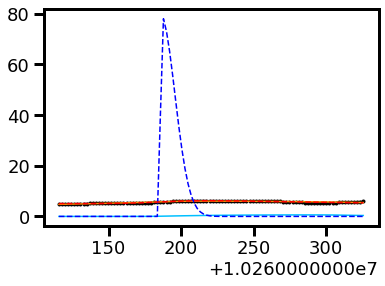

2.3438766591077167


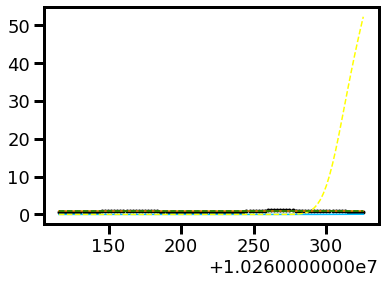

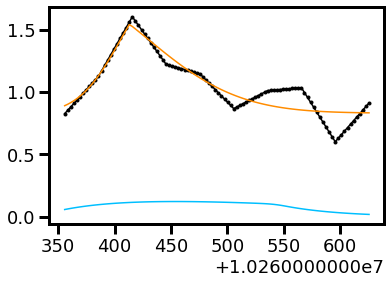

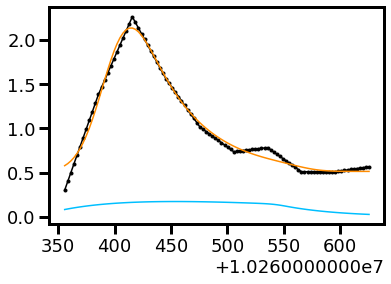

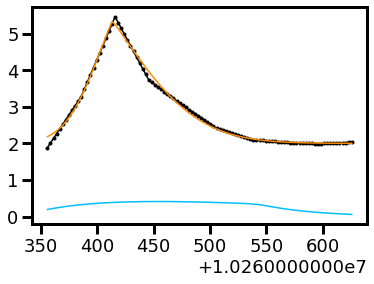

[10260415.66579151]


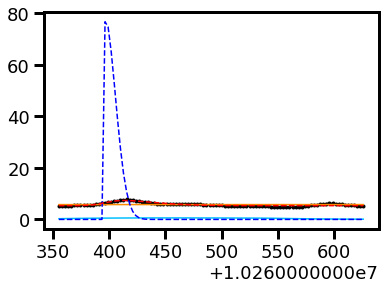

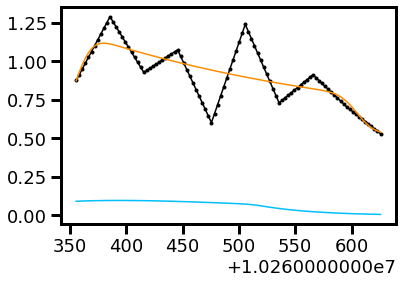

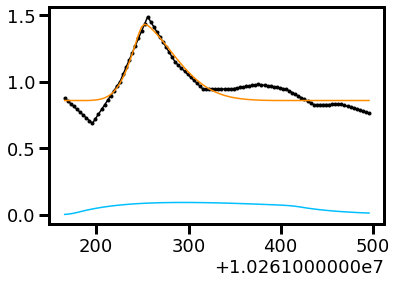

[10261255.66579151]


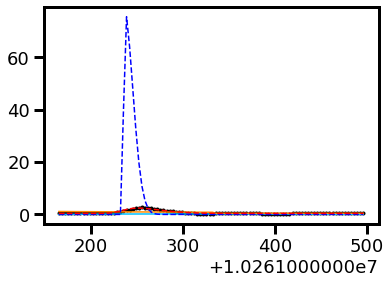

55.36133580806471
[10261255.66579151]


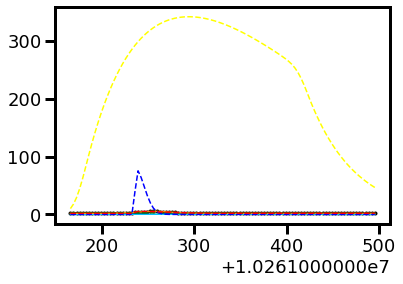

[10261255.66579151]


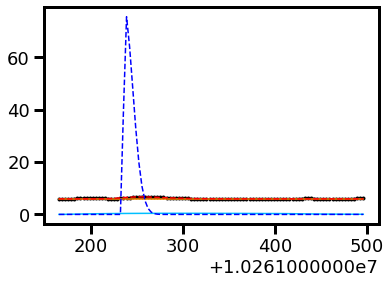

2.2654865072068837


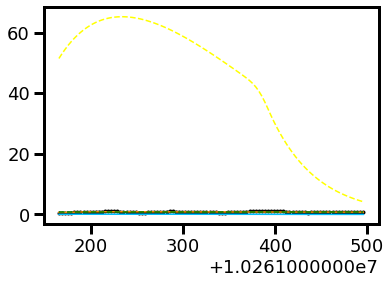

In [15]:
fmodels_25 = []

for j in [4,-4,-3,-1]:
    temp_f = []
    temp_l = []
    mask = f_int[j] > 0
    
    for ion in ions:

        upsample = np.linspace(fwc.time[mask].min(), fwc.time[mask].max(), 100)
        
        if ion != 'CIII':
            finterp = interp1d(fwc.time[mask], fwc.width_table[ion][mask]/1e-12)
            einterp = interp1d(fwc.time[mask], fwc.error_table[ion][mask]/1e-12)
            scaling=1e-12
        else:
            finterp = interp1d(fwc.time[mask], fwc.width_table[ion][mask]/1e-11)
            einterp = interp1d(fwc.time[mask], fwc.error_table[ion][mask]/1e-11)
            scaling=1e-11

        plt.plot(upsample, finterp(upsample), 'k', marker='.')

        t0, amp = multi_peaks(fwc.time[mask], fwc.width_table[ion][mask])
            
        rise, decay = [10,10,10],[50,50,50] 

        out = fwc.fit_flare(ion=ion, mask=mask,  model='convolved',
                            eta=t0[:1], omega=[200], alpha=[100], offset=0.5,
                            amp=amp[:1]/scaling, t0=t0[:1], rise=[10], decay=[50],
                            x=upsample.value, y=finterp(upsample),
                            yerr=einterp(upsample))

        plt.plot(upsample, out[-2], color='deepskyblue')
        plt.plot(upsample, out[-1].best_fit, color='darkorange')

        if out[-1].chisqr > 2 and out[-1].chisqr <= 3:
            out = fwc.fit_flare(ion=ion, mask=mask,  model='convolved',
                            eta=t0[:1], omega=[200], alpha=[50], offset=1,
                            amp=amp[:1]/scaling*1000, t0=t0[:1], rise=[10], decay=[50],
                            x=upsample.value, y=finterp(upsample),
                            yerr=einterp(upsample))
            plt.plot(upsample, out[-2], '--', color='yellow')
            plt.plot(upsample, out[-1].best_fit, '--', color='green')
            print(out[-1].chisqr)
        
        if out[-1].chisqr > 3:
            print(t0[:1])
            out = fwc.fit_flare(ion=ion, mask=mask,  model='skewed gaussian',
                            eta=t0[:1]-20, omega=[10], alpha=[20], offset=1,
                            amp=amp[:1]/scaling*10, t0=t0[:1]-20, rise=[5], decay=[50],
                            x=upsample.value, y=finterp(upsample),
                            yerr=einterp(upsample))
            plt.plot(upsample, out[-2], '--', color='blue')
            plt.plot(upsample, out[-1].best_fit, '--', color='red')
        
        temp_f.append(out)
        plt.show()

    fmodels_25.append(temp_f)

In [16]:
oot = np.nansum(f_int, axis=0)==0
qlines = []
for ion in ions:
    ngauss = fwc.line_table[fwc.line_table['ion']==ion]['ngauss'].value[0] + 0
    args = fwc.model_line_shape(ion=ion,
                                mask=oot, 
                                ngauss=ngauss, 
                                ext=50)
    qlines.append(args)

/Users/arcticfox/opt/anaconda3/lib/python3.9/site-packages/lightkurve/lightcurve.py:1042: LightkurveWarning: The light curve appears to be zero-centered (median=2.38e-14 +/- 5.29e-14); `normalize()` will divide the light curve by a value close to zero, which is probably not what you want.
  warnings.warn(


In [17]:
def duration(zeroed, time):
    med = np.nanmedian(zeroed)
    qmask = zeroed<0.5*med
    fmask = zeroed>=0.5*med
    fq = np.nanmedian(zeroed[qmask])
    
    plt.plot(time[fmask], zeroed[fmask],'.')
    plt.plot(time[qmask], zeroed[qmask],'.')
    plt.show()
    return np.trapz(((zeroed[fmask]-fq)/fq),x=time[fmask]*units.s)

bad


/var/folders/gz/h7_ym7m52dlgq4xpllc1x3m40000gn/T/ipykernel_31231/2394018965.py:150: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('/Users/arcticfox/Documents/AUMic/paper/models.pdf', rasterize=True,


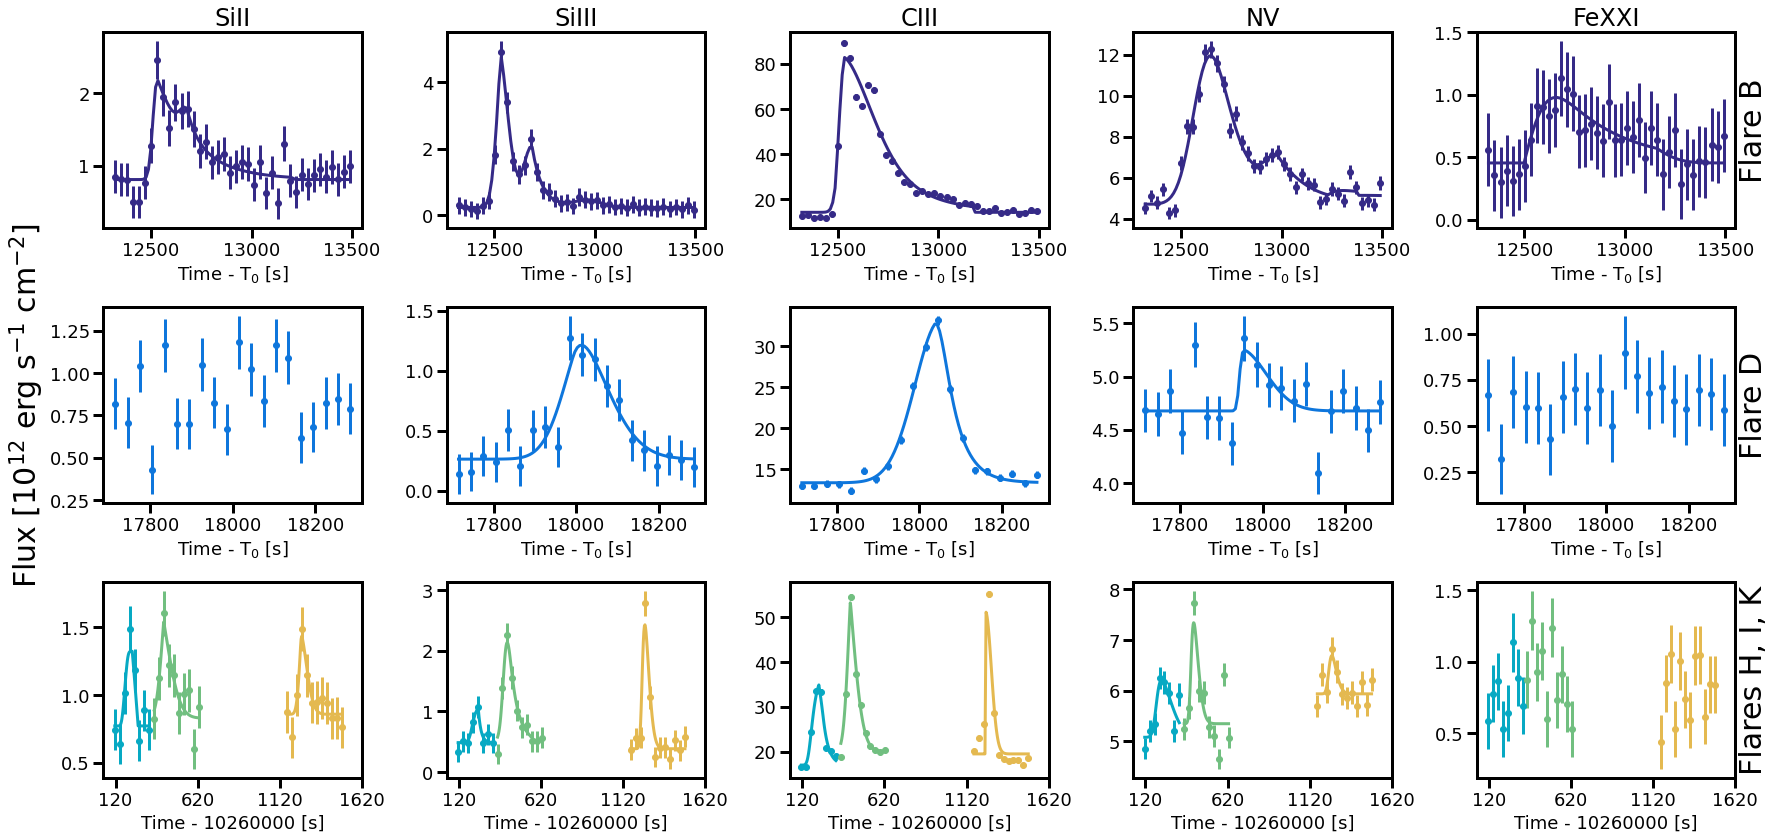

In [28]:
fig = plt.figure(tight_layout=True, figsize=(25,12))
fig.set_facecolor('w')
gs = gridspec.GridSpec(3,5, width_ratios=[3.5,3.5,3.5,3.5,3.5])
ax01 = fig.add_subplot(gs[0,0])
ax03 = fig.add_subplot(gs[0,1])
ax05 = fig.add_subplot(gs[0,2])
ax07 = fig.add_subplot(gs[0,4])
ax09 = fig.add_subplot(gs[0,3])

ax11 = fig.add_subplot(gs[1,0])
ax33 = fig.add_subplot(gs[1,1])
ax55 = fig.add_subplot(gs[1,2])
ax77 = fig.add_subplot(gs[1,4])
ax99 = fig.add_subplot(gs[1,3])

ax1 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[2,1])
ax5 = fig.add_subplot(gs[2,2])
ax7 = fig.add_subplot(gs[2,4])
ax9 = fig.add_subplot(gs[2,3])

#eax = fig.add_subplot(gs[0:,5:])

faxes = [ax1,ax3,ax5,ax9,ax7]
bigax = [ax01,ax03,ax05,ax09,ax07]
dax = [ax11,ax33,ax55,ax99,ax77]
#laxes = [ax2,ax4,ax6,ax8]

if COLOR == 'k':
    ion_colors = parula[np.linspace(0,200,5,dtype=int)]
else:
    ion_colors = parula[np.linspace(80,230,5,dtype=int)]
    
formtemp = np.array([4.5, 4.7, 4.8, 5.2, 7.1])
x = 0
ind = [2,4,-4,-3,-1]
energies = []
durations = []

xy = ax7.twinx()
xy.set_ylabel('Flares H, I, K', fontsize=30)
xy.set_yticks([])

xy = ax77.twinx()
xy.set_ylabel('Flare D', fontsize=30)
xy.set_yticks([])

xy = ax07.twinx()
xy.set_ylabel('Flare B', fontsize=30,x=3)
xy.set_yticks([])

for n in range(len(fmodels_25)+1):
    tempe = []
    tempd = []
    for i in [0,1,2,3,4]:
        mask = f_int[ind[n]] > 0
        qmask = f_int[ind[n]] == 0

        if n == 0:
            
            if ions[i] != 'CIII':
                bigax[i].plot(fmodels[n][i][0],
                          fmodels[n][i][-1].best_fit,#/1e12,
                          c=ion_colors[x], lw=3)
                fm = fmodels[n][i][-1].best_fit#/1e12
                
            else:
                bigax[i].plot(fmodels[n][i][0],
                          fmodels[n][i][-1].best_fit*10,#/1e11,
                          c=ion_colors[x], lw=3)
                fm = fmodels[n][i][-1].best_fit*10#/1e11
                
            bigax[i].errorbar(fwc.time[mask].value,
                                  fwc.width_table[ions[i]][mask]/1e-12,
                                  yerr=fwc.error_table[ions[i]][mask].value/1e-12/2, 
                                  c=ion_colors[x], linestyle='', lw=3, marker='o')
            
            bigax[i].set_title(ions[i], fontsize=24)
            
            if i == 3:
                bigax[i].set_title('NV', fontsize=24)

            bigax[i].set_xticks([12500, 13000, 13500])
            
            bigax[i].set_xlabel('Time - T$_0$ [s]')
            bigax[i].set_rasterized(True)
    
            
            zeroed = fm - np.nanmin(fm)
            e = np.trapz(zeroed*units.erg/units.s/units.cm**2, 
                              x=fmodels[n][i][0]*units.s)*4*np.pi*distance**2
            _,d = fwc.measure_flare_params(qmask=qmask, fmask=mask, d=distance,
                                               flux=fwc.width_table[ions[i]])
        
        else:
            if n == 1:
                xx = dax
            else:
                xx = faxes

            xx[i].errorbar(fwc.time[mask].value,
                              fwc.width_table[ions[i]][mask]/1e-12,
                              yerr=fwc.error_table[ions[i]][mask]/1e-12/3,
                              c=ion_colors[x], linestyle='', lw=3, marker='o')
            
            if ions[i] != 'FeXXI':
                if ions[i] != 'CIII':
                    if n == 1 and ions[i] == 'SiII':
                        print('bad')
                        pass
                    else:
                        xx[i].plot(fmodels_25[n-1][i][0],
                                      fmodels_25[n-1][i][-1].best_fit,#/1e12,
                                      c=ion_colors[x], lw=3)
                        fm = fmodels_25[n-1][i][-1].best_fit#/1e12
                else:
                    xx[i].plot(fmodels_25[n-1][i][0],
                                  fmodels_25[n-1][i][-1].best_fit*10,#/1e11,
                                  c=ion_colors[x], lw=3)
                    fm = fmodels_25[n-1][i][-1].best_fit*10#/1e11


            zeroed = fm - np.nanmin(fm)
            e = np.trapz(zeroed*units.erg/units.s/units.cm**2, 
                          x=fmodels_25[n-1][i][0]*units.s)*4*np.pi*distance**2

            _,d = fwc.measure_flare_params(qmask=qmask, fmask=mask, d=distance,
                                           flux=fwc.width_table[ions[i]])
            if n > 1:
                xx[i].set_xticks(np.array([10260120, 10260620, 10261120, 10261620]))
                xx[i].set_xticklabels(np.array([10260120, 10260620, 10261120, 10261620])-10260000)
                xx[i].set_xlabel('Time - 10260000 [s]')
                xx[i].set_rasterized(True)
            else:
                xx[i].set_xlabel('Time - T$_0$ [s]')
        
        tempe.append(e.value)
        tempd.append(d.value)

        
    x += 1
    energies.append(tempe)
    durations.append(tempd)
    

ax11.set_ylabel('Flux [10$^{12}$ erg s$^{-1}$ cm$^{-2}$]', fontsize=30)


plt.subplots_adjust(wspace=0.)
plt.savefig('/Users/arcticfox/Documents/AUMic/paper/models.pdf', rasterize=True,
            dpi=300, bbox_inches='tight')#, transparent=True)

## Second Plot

------


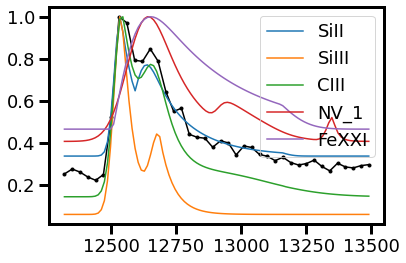

------


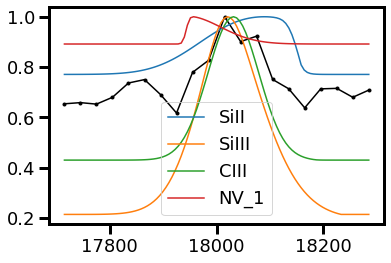

------


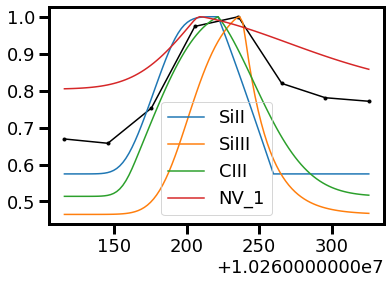

------


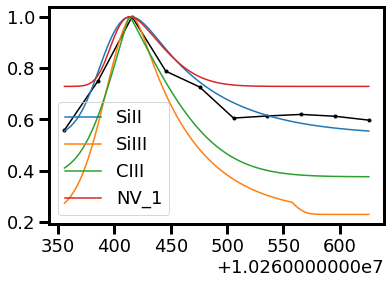

------


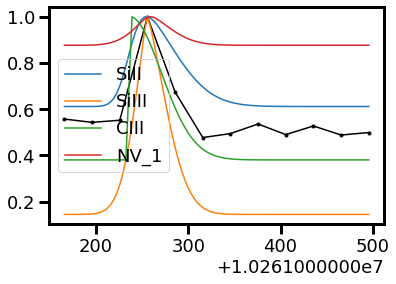

In [550]:
deltat = np.zeros((5,6))

ints = [2,4,-4,-3,-1]

for i in range(5):
    peak_all = np.argmax(fmodels_all[i][-1].best_fit)
    
    fq = f_int[ints[i]]>0
    plt.plot(fwc.time[fq], f[fq]/np.nanmax(f[fq]), 'k', marker='.')
    
    if i == 0:
        deltat[i][0] = fmodels_all[i][0][peak_all]
        for j in range(5):
            peak = np.argmax(fmodels[i][j][-1].best_fit)
            deltat[i][j+1] = fmodels[i][j][0][peak]
            plt.plot(fmodels[i][j][0], 
                     fmodels[i][j][-1].best_fit/np.nanmax(fmodels[i][j][-1].best_fit),
                     label=ions[j])
            
    else:
        deltat[i][0] = fmodels_all[i][0][peak_all]

        for j in range(len(fmodels_25[i-1])-1):
            peak = np.argmax(fmodels_25[i-1][j][-1].best_fit)
            deltat[i][j+1] = fmodels_25[i-1][j][0][peak]
            plt.plot(fmodels_25[i-1][j][0], 
                     fmodels_25[i-1][j][-1].best_fit/np.nanmax(fmodels_25[i-1][j][-1].best_fit),
                     label=ions[j])
        if ints[i] == 4:
            deltat[i][1] = 0
    plt.legend()
    print('------')
    plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6


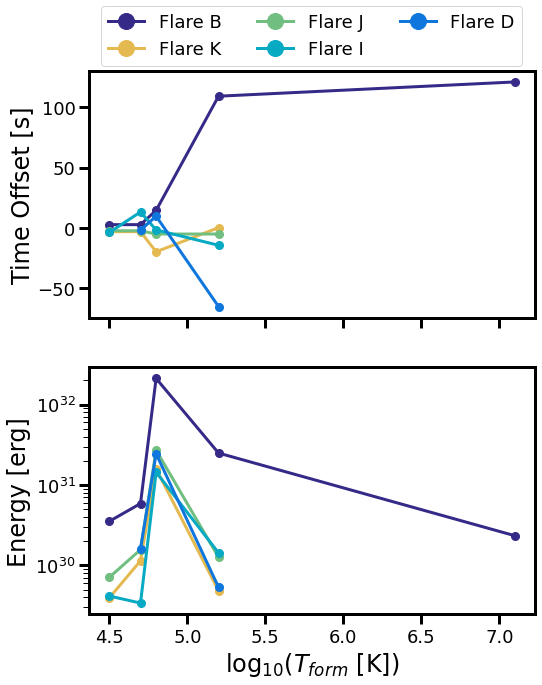

In [582]:
fig, (tax,eax) = plt.subplots(nrows=2, figsize=(8,10), sharex=True)

tax.set_ylabel('Time Offset [s]',fontsize=24)

letters = ['B', 'D', 'I', 'J', 'K']
ms=8
for i in [0,4,3,2,1]:#range(len(energies)):
    q = np.array(energies[i]) > 0
    if i < 1:
        eax.plot(formtemp[q], np.array(energies[i])[q]/1e12, 
                     c=ion_colors[i] ,marker='o', lw=3, ms=ms)
    elif i >= 2:
        eax.plot(formtemp[q][:-1], np.array(energies[i])[q][:-1]/1e12, 
                     c=ion_colors[i] ,marker='o', lw=3, ms=ms)
    else:
        eax.plot(formtemp[q][1:-1], np.array(energies[i])[q][1:-1]/1e12, 
                     c=ion_colors[i] ,marker='o', lw=3, ms=ms)
        
    q = (deltat[i][1:] - deltat[i][0]) > -200
    tax.plot(formtemp[q], (deltat[i][1:] - deltat[i][0])[q],
             c=ion_colors[i], marker='o', lw=3, ms=ms,
             label='Flare {}'.format(letters[i]))
tax.legend(bbox_to_anchor=(0.027, 1.02, 1.0, .12), loc=3,
           ncol=3, borderaxespad=0.)    
eax.set_yscale('log')
eax.set_ylabel('Energy [erg]',fontsize=24)
eax.set_xlabel('log$_{10}$($T_{form}$ [K])',fontsize=24)

tax.set_rasterized(True)
eax.set_rasterized(True)

plt.savefig('/Users/arcticfox/Documents/AUMic/paper/time_energy.pdf',
            dpi=300, rasterize=True, bbox_inches='tight')

In [577]:
np.array(energies[1])/1e12

array([1.13584405e+30, 1.60567183e+30, 2.44317553e+31, 5.33173237e+29,
       5.33173237e+29])

## For presentations

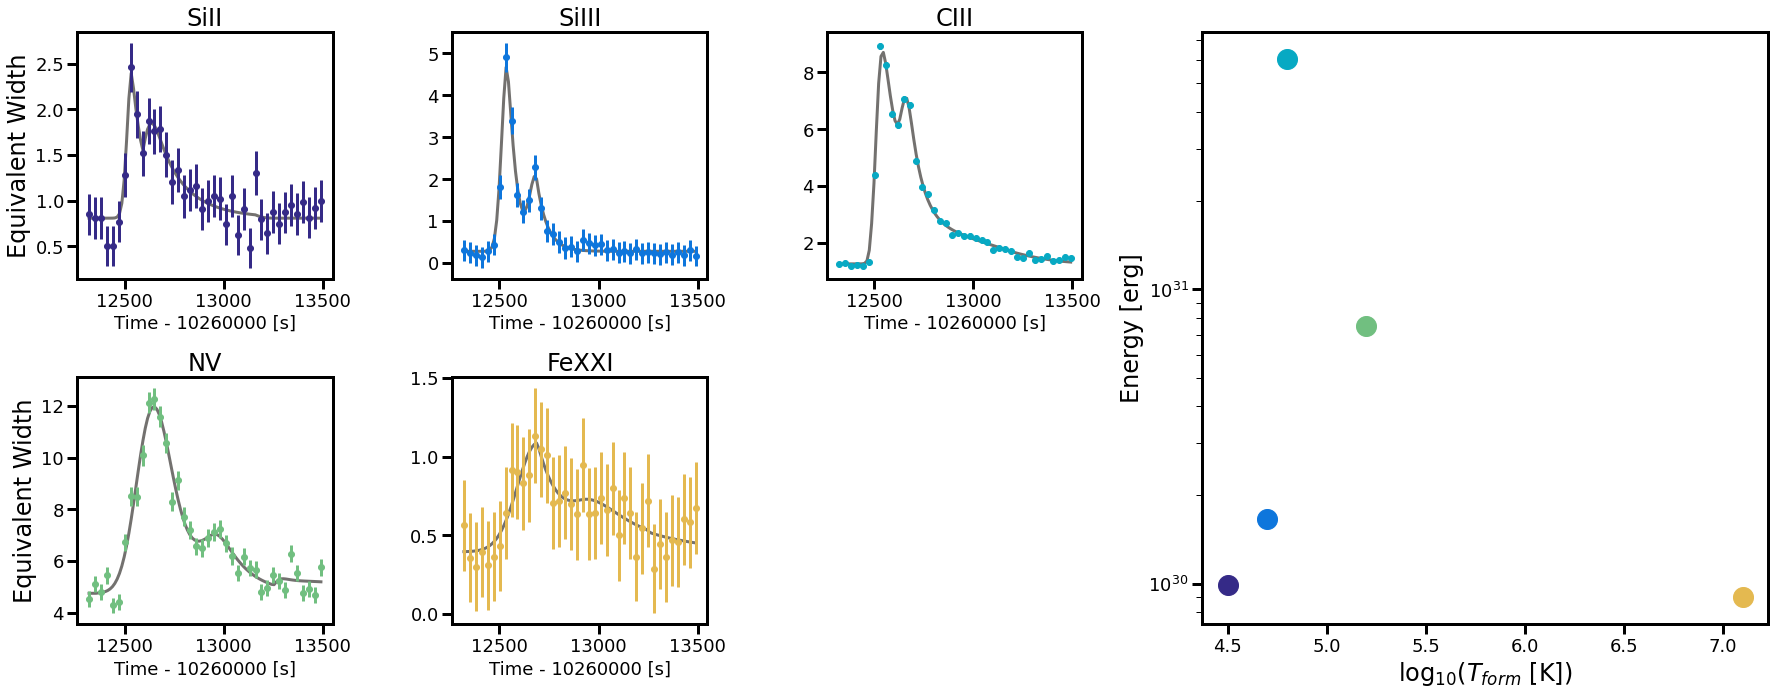

In [273]:
fig = plt.figure(tight_layout=True, figsize=(25,10))
fig.set_facecolor('w')
gs = gridspec.GridSpec(2,5, width_ratios=[4,4,4,2,5])
ax11 = fig.add_subplot(gs[0,0])
ax33 = fig.add_subplot(gs[0,1])
ax55 = fig.add_subplot(gs[0,2])
ax77 = fig.add_subplot(gs[1,1])
ax99 = fig.add_subplot(gs[1,0])

eax = fig.add_subplot(gs[0:,3:])

bigax = [ax11,ax33,ax55,ax99,ax77]
#laxes = [ax2,ax4,ax6,ax8]

if COLOR == 'k':
    ion_colors = parula[np.linspace(0,200,5,dtype=int)]
else:
    ion_colors = parula[np.linspace(80,235,5,dtype=int)]
    
formtemp = np.array([4.5, 4.7, 4.8, 5.2, 7.1])
x = 0
ind = [2,-4,-3,-2,-1]
energies = []
durations = []

for n in range(len(fmodels)):
    tempe = []
    tempd = []
    for i in [0,1,2,3,4]:
        mask = f_int[ind[n]] > 0
        qmask = f_int[ind[n]] == 0

        if n == 0:
            
            if ions[i] != 'CIII':
            #    bigax[i].plot(fmodels[n][i][0],
            #              fmodels[n][i][-1].best_fit/1e12,
            #              c=ion_colors[x], lw=3)
            #    fm = fmodels[n][i][-1].best_fit/1e12
                scale = 1e12
                
            else:
                scale = 1e11
            bigax[i].plot(fmodels[n][i][0],
                          fmodels[n][i][-1].best_fit,
                          c='#73716f', lw=3)
            fm = fmodels[n][i][-1].best_fit
                
            bigax[i].errorbar(fwc.time[mask].value,
                                  fwc.width_table[ions[i]][mask]*scale,
                                  yerr=fwc.error_table[ions[i]][mask].value/2*scale, 
                                  c=ion_colors[i], linestyle='', lw=3, marker='o')
            
            bigax[i].set_title(ions[i], fontsize=24)
            
            if i == 3:
                bigax[i].set_title('NV', fontsize=24)

            bigax[i].set_xticks([12500, 13000, 13500])
            
            bigax[i].set_xlabel('Time [s]')
            bigax[i].set_rasterized(True)
    
            
            zeroed = fm - np.nanmin(fm)
            e = np.trapz(zeroed*units.erg/units.s/units.cm**2, 
                              x=fmodels[n][i][0]*units.s)*4*np.pi*distance**2
            _,d = fwc.measure_flare_params(qmask=qmask, fmask=mask, d=distance,
                                               flux=fwc.width_table[ions[i]])
        

            zeroed = fm/scale - np.nanmin(fm/scale)
            e = np.trapz(zeroed*units.erg/units.s/units.cm**2, 
                          x=fmodels_25[n-1][i][0]*units.s)*4*np.pi*distance**2

            _,d = fwc.measure_flare_params(qmask=qmask, fmask=mask, d=distance,
                                           flux=fwc.width_table[ions[i]])

        #bigax[i].set_xticks(np.array([10260120, 10260620, 10261120, 10261620]))
        #bigax[i].set_xticklabels(np.array([10260120, 10260620, 10261120, 10261620])-10260000)
        bigax[i].set_xlabel('Time - 10260000 [s]')
        faxes[i].set_rasterized(True)
        
        tempe.append(e.value)
        tempd.append(d.value)
        
    x += 1
    energies.append(tempe)
    durations.append(tempd)
    
    #ax3.plot(formtemp[i], e, 'o', ms=10)
    
for i in range(len(energies)):
    q = np.array(energies[i]) > 0
    if i == 0:
        for j in range(len(formtemp[q])):
            eax.plot(formtemp[q][j], np.array(energies[i])[q][j], 
                         c=ion_colors[j] ,marker='o', lw=3, ms=20)
    else:
        eax.plot(formtemp[q][:-1], np.array(energies[i])[q][:-1], 
                     c=ion_colors[i] ,marker='o', lw=3, ms=10)

eax.set_yscale('log')
eax.set_ylabel('Energy [erg]',fontsize=24)
eax.set_xlabel('log$_{10}$($T_{form}$ [K])',fontsize=24)
    
#ax11.set_title('Visit 1 Orbit 2')
#ax1.set_title('Visit 2 Orbit 5')
#ax3.set_yscale('log')
ax11.set_ylabel('Equivalent Width', fontsize=24)
ax99.set_ylabel('Equivalent Width', fontsize=24)


plt.subplots_adjust(wspace=0.)
#plt.savefig('/Users/arcticfox/Documents/AUMic/figures/flare_wavelength.png', rasterize=True,
#            dpi=300, bbox_inches='tight', transparent=True)

In [ ]:
ion_colors